# Check State Estimates
Make sure they're not unreasonable by plotting them

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moirae.interface import iterate_records_from_file
from battdat.data import CellDataset
from pathlib import Path
from tqdm import tqdm
import tables as tb
import pandas as pd

Config

In [2]:
asoh_file = 'asoh-estimates/batch_B12A_cell_4.asoh.h5'

## Display the Estimated Voltage for a Single Cell
Show that it tracks the voltages observed in cycling decently well

In [3]:
with tb.open_file(asoh_file) as file:
    table = file.get_node('/state_estimates/per_timestep')
    root = file.get_node('/state_estimates/')
    est_volt = table[:]['output_mean'][:, 0]
    state_names = root._v_attrs['state_names']
    est_asoh = pd.DataFrame(table[:]['state_mean'], columns=state_names)

In [4]:
real_data = CellDataset.from_hdf(f'../../publishing-camp-data/data/hdf5/refined/{Path(asoh_file).name[:-8]}.h5')

C:\Users\lward\AppData\Local\miniconda3\envs\roviweb\Lib\site-packages\battdat\data.py:56: UserWarning: Metadata was created in a different version of battdat. supplied=0.4.0, current=0.4.2.
  warnings.warn(f'Metadata was created in a different version of battdat. supplied={supplied_version}, current={__version__}.')


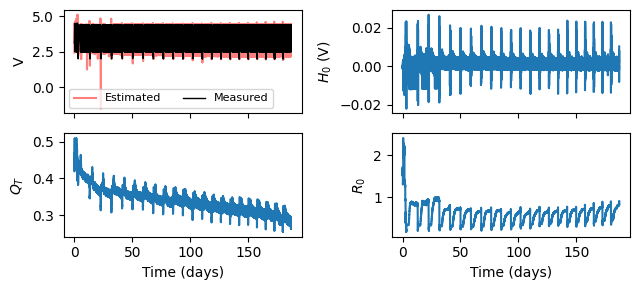

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(6.5, 3.), sharex=True)

axs[0, 0].plot(real_data.raw_data['test_time'][1:] / 3600 / 24, est_volt, color='r', alpha=0.5, label='Estimated')
axs[0, 0].plot(real_data.raw_data['test_time'] / 3600 / 24, real_data.raw_data['voltage'], color='k', lw=1, label='Measured')
axs[0, 0].set_ylabel('V')
axs[0, 0].legend(ncols=2, fontsize=8)

axs[0, 1].plot(real_data.raw_data['test_time'][1:] / 3600 / 24, est_asoh['hyst'])
axs[0, 1].set_ylabel('$H_0$ (V)')

axs[1, 0].plot(real_data.raw_data['test_time'][1:] / 3600 / 24, est_asoh['q_t.base_values'])
axs[1, 0].set_ylabel('$Q_T$')

axs[1, 1].plot(real_data.raw_data['test_time'][1:] / 3600 / 24, est_asoh['r0.base_values'])
axs[1, 1].set_ylabel('$R_0$')

for ax in axs[-1, :]:
    ax.set_xlabel('Time (days)')

fig.tight_layout()

## Plot the capacity for many cells
Show the $Q_T$ over time for every cell we've run estimation on

In [6]:
all_qts = {}
for path in tqdm(Path('asoh-estimates').glob('*h5')):
    with tb.open_file(path) as file:
        table = file.get_node('/state_estimates/per_timestep')
        root = file.get_node('/state_estimates/')
        est_volt = table[:]['output_mean'][:, 0]
        state_names = root._v_attrs['state_names']
        est_asoh = pd.DataFrame(table[:]['state_mean'], columns=state_names)
        est_asoh['time'] = table[:]['time']
        all_qts[path.name[:-8]] = est_asoh

10it [00:01,  5.62it/s]


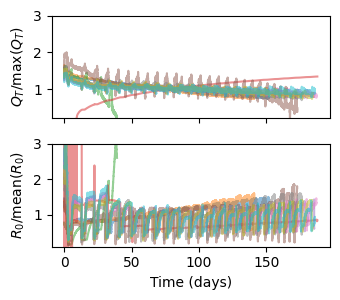

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 3.1), sharex=True)

for qt in all_qts.values():
    axs[0].plot(qt['time'] / 3600 / 24, qt['q_t.base_values'] / qt['q_t.base_values'].mean(), alpha=0.5)
    axs[1].plot(qt['time'] / 3600 / 24, qt['r0.base_values'] / qt['r0.base_values'].mean(), alpha=0.5)

axs[0].set_ylim([0.2, 3.0])
axs[1].set_ylim([0.1, 3.0])

axs[0].set_ylabel('$Q_T / \\max(Q_T)$')
axs[1].set_ylabel('$R_0 / \\mathrm{mean}(R_0)$')

axs[-1].set_xlabel('Time (days)')

fig.tight_layout()